# <font color = 'red'> Strategy </font>
### Bollinger bands are comprised of a simple moving average along with upper and lower bands (typically 2 STDDEV away). The bands widen and narrow as the volatility of the underlying asset changes. 

# <font color = 'red'> 1. Configuration </font>

In [68]:
!pip3 install ta
!pip3 install dash

# <font color = 'red'> 1.1. Indicator Imports </font>

In [1]:
#Technical Indicators
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice
from ta.volatility import KeltnerChannel
from ta.momentum import ROCIndicator

# Plotting
import matplotlib.pyplot as plt

#Getting data
import yfinance as yf
import math
import pandas as pd
import numpy as np

# <font color = 'red'> 1.2. Initalizing Stocks and Period </font>

In [2]:
meta = 'META'
amazon = "AMZN"
apple = "AAPL"
netflix = 'NFLX'
google = 'GOOGL'

stockList = {meta : {}, amazon: {}, apple: {}, netflix: {}, google: {}}
stockData = {}
weight = 0.2

start = '2015-01-01'
end = '2019-12-31'

# <font color = 'red'> 1.3. Visualizing MAANG Stock Prices from 2015 - 2019 </font>

Text(0.5, 1.0, 'MAANG Stock Closing Price from 2015 - 2019')

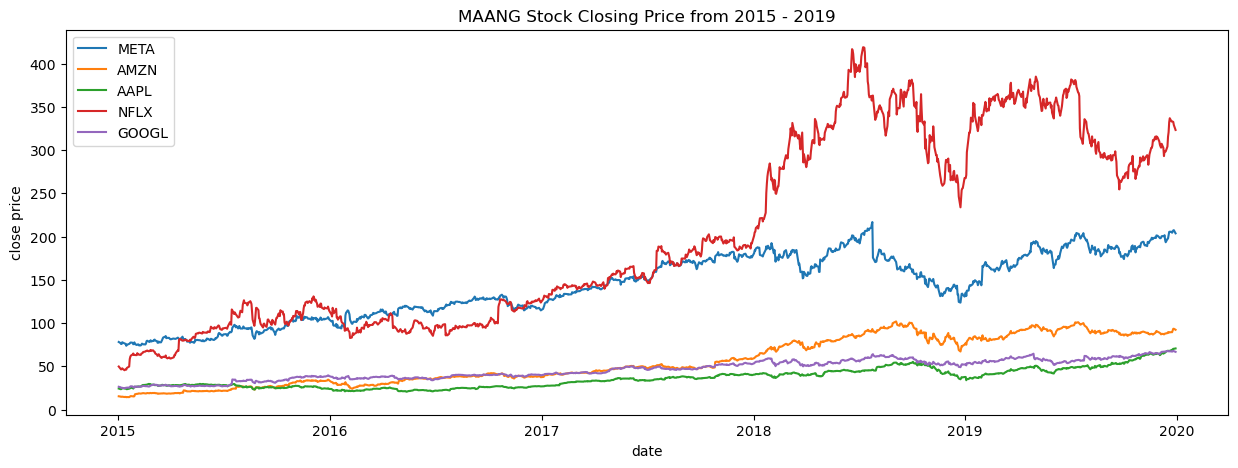

In [3]:
fig = plt.figure(figsize=(15, 5))
for stock in stockList.keys():
	hist_stock = yf.Ticker(stock).history(start = start, end = end)
	stockList[stock]['info'] = hist_stock
	plt.plot(hist_stock.index, hist_stock['Close'], label=f"{stock}")
	plt.legend()

plt.xlabel('date')
plt.ylabel('close price')
plt.title('MAANG Stock Closing Price from 2015 - 2019')

<hr>

# <font color = 'red'> 2. Long/Short Strategy Logic </font>

In [4]:
def conditionGenerator(ema, bb_low, bb_high, close_price, prev):

    ## Long -- Close price < Lower band & Close price > Exponential Moving Average
    if close_price < bb_low and close_price > ema:
        return 1
    
    ## Short -- Close price > Lower band & Close price < Exponential Moving Averag
    elif close_price > bb_high and close_price < ema:
        return -1
        
    ## Other potential signals
    #elif (close_price >= bb_low and close_price <= bb_high) and close_price > ema:
    #    return 1
    
    #elif close_price < bb_low and close_price < ema: # similar
    #    return 1

    else:
        return prev

Logic:


- Long rationale -- 


- Short rationale -- 

<hr>

# <font color = 'red'> 3. Implementing Exponential Moving Average and Bollinger Bands Strategy </font>

In [5]:
pd.options.mode.chained_assignment = None

# Define the strategy function
def strategy(stock):
    # Download stock data from Yahoo Finance
    data = yf.download(stock, start=start, end=end)
    
    # Calculate the 200-day EMA
    data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()

    # Calculate bollinger bands
    bollingerbands = BollingerBands(close=data['Close'], window=20, window_dev=2)
    high = bollingerbands.bollinger_hband()
    low = bollingerbands.bollinger_lband()
    med = bollingerbands.bollinger_mavg()

    data['bb_high'] = high
    data['bb_low'] = low
    data['bb_mid'] = med

    # Initialize position
    data['Position'] = 0  # 1 for long, -1 for short

    # Signal generation based on EMA and MACD
    for i in range(1, len(data)):
        ema = data['EMA_200'].iloc[i]
        bb_high = data['bb_high'].iloc[i]
        bb_low = data['bb_low'].iloc[i]
        prev = data['Position'].iloc[i-1]
        close = data['Close'].iloc[i]

        data['Position'].iloc[i] = conditionGenerator(ema, bb_low, bb_high, close, prev)

    return data

# Run the strategy for each MAANG stock
for stock in stockList:
    stockList[stock]['strat'] = strategy(stock)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<hr>

# <font color = 'red'> 4. Trading Signals Visualisation</font>

# <font color = 'red'> 4.1. Meta Trading Signals </font>

In [56]:
stockList[meta]['strat']

,Open,High,Low,Close,Adj Close,Volume,EMA_200,bb_high,bb_low,bb_mid,Position
Date,,,,,,,,,,,
2015-01-02,78.580002,78.930000,77.699997,78.449997,78.214500,18177500,78.449997,NaN,NaN,NaN,0
2015-01-05,77.980003,79.250000,76.860001,77.190002,76.958290,26452200,78.437460,NaN,NaN,NaN,0
2015-01-06,77.230003,77.589996,75.360001,76.150002,75.921410,27399300,78.414699,NaN,NaN,NaN,0
2015-01-07,76.760002,77.360001,75.820000,76.150002,75.921410,22045300,78.392165,NaN,NaN,NaN,0
2015-01-08,76.739998,78.230003,76.080002,78.180000,77.945312,23961000,78.390054,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,206.699997,208.589996,205.679993,206.179993,205.561066,13348900,186.006692,206.719622,194.552376,200.635999,1
2019-12-24,206.300003,206.789993,205.000000,205.119995,204.504257,6046300,186.196874,207.274664,194.530335,200.902499,1
2019-12-26,205.570007,207.820007,205.309998,207.789993,207.166229,9350700,186.411731,208.312513,194.374485,201.343499,1


# <font color = 'red'> 4.2. Apple Trading Signals </font>

In [57]:
stockList[apple]['strat']

,Open,High,Low,Close,Adj Close,Volume,EMA_200,bb_high,bb_low,bb_mid,Position
Date,,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373964,212818400,27.332500,NaN,NaN,NaN,0
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687302,257142000,27.324839,NaN,NaN,NaN,0
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689529,263188400,27.317278,NaN,NaN,NaN,0
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021708,160423600,27.313499,NaN,NaN,NaN,0
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944681,237458000,27.320057,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,70.132500,71.062500,70.092499,71.000000,68.909012,98572000,56.152818,71.314653,64.276346,67.795499,1
2019-12-24,71.172501,71.222504,70.730003,71.067497,68.974495,48478800,56.301223,71.765706,64.272793,68.019249,1
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.342987,93121200,56.462181,72.443513,64.235485,68.339499,1


# <font color = 'red'> 4.3. Amazon Trading Signals </font>

In [58]:
stockList[amazon]['strat']

,Open,High,Low,Close,Adj Close,Volume,EMA_200,bb_high,bb_low,bb_mid,Position
Date,,,,,,,,,,,
2015-01-02,15.629000,15.737500,15.348000,15.426000,15.426000,55664000,15.426000,NaN,NaN,NaN,0
2015-01-05,15.350500,15.419000,15.042500,15.109500,15.109500,55484000,15.422850,NaN,NaN,NaN,0
2015-01-06,15.112000,15.150000,14.619000,14.764500,14.764500,70380000,15.416300,NaN,NaN,NaN,0
2015-01-07,14.875000,15.064000,14.766500,14.921000,14.921000,52806000,15.411371,NaN,NaN,NaN,0
2015-01-08,15.016000,15.157000,14.805500,15.023000,15.023000,61768000,15.407507,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,89.413002,89.650002,89.225502,89.650002,89.650002,42728000,89.058414,90.811545,86.532506,88.672025,1
2019-12-24,89.690498,89.778503,89.378998,89.460503,89.460503,17626000,89.062415,90.877453,86.543448,88.710450,1
2019-12-26,90.050499,93.523003,89.974998,93.438499,93.438499,120108000,89.105958,91.853039,85.927012,88.890025,1


# <font color = 'red'> 4.4. Netflix Trading Signals </font>

In [59]:
stockList[netflix]['strat']

,Open,High,Low,Close,Adj Close,Volume,EMA_200,bb_high,bb_low,bb_mid,Position
Date,,,,,,,,,,,
2015-01-02,49.151428,50.331429,48.731430,49.848572,49.848572,13475000,49.848572,NaN,NaN,NaN,0
2015-01-05,49.258572,49.258572,47.147144,47.311428,47.311428,18165000,49.823327,NaN,NaN,NaN,0
2015-01-06,47.347141,47.639999,45.661430,46.501431,46.501431,16037700,49.790273,NaN,NaN,NaN,0
2015-01-07,47.347141,47.421429,46.271427,46.742859,46.742859,9849700,49.759950,NaN,NaN,NaN,0
2015-01-08,47.119999,47.835712,46.478573,47.779999,47.779999,9601900,49.740249,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,337.760010,337.950012,331.019989,333.100006,333.100006,5765300,312.562129,334.974713,287.376282,311.175497,-1
2019-12-24,334.010010,335.700012,331.600006,333.200012,333.200012,2019300,312.767482,337.679787,286.436210,312.057999,-1
2019-12-26,334.600006,336.459991,332.010010,332.630005,332.630005,3589900,312.965119,340.213185,285.916813,313.064999,-1


# <font color = 'red'> 4.5. Google Trading Signals </font>

In [60]:
stockList[google]['strat']

,Open,High,Low,Close,Adj Close,Volume,EMA_200,bb_high,bb_low,bb_mid,Position
Date,,,,,,,,,,,
2015-01-02,26.629999,26.790001,26.393999,26.477501,26.412100,26480000,26.477501,NaN,NaN,NaN,0
2015-01-05,26.357500,26.399500,25.887501,25.973000,25.908844,41182000,26.472481,NaN,NaN,NaN,0
2015-01-06,26.025000,26.060499,25.277500,25.332001,25.269430,54456000,26.461133,NaN,NaN,NaN,0
2015-01-07,25.547501,25.574499,25.182501,25.257500,25.195112,46918000,26.449156,NaN,NaN,NaN,0
2015-01-08,25.075500,25.375000,24.750999,25.345501,25.282898,73054000,26.438175,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,67.936501,68.092499,67.400002,67.531502,67.364700,19936000,60.958881,68.835142,64.440007,66.637574,1
2019-12-24,67.510498,67.600502,67.208504,67.221497,67.055450,13468000,61.021195,68.854069,64.615030,66.734549,1
2019-12-26,67.327499,68.160004,67.275497,68.123497,67.955231,23662000,61.091865,68.998730,64.717718,66.858224,1


# <font color = 'red'> 4.6. Trading Signal Visualizations </font>

# <font color = 'red'> 4.6.1. Overview of Signals </font>

# <font color = 'red'> 4.6.1.1 Buy/Sell Signal of Stock </font>

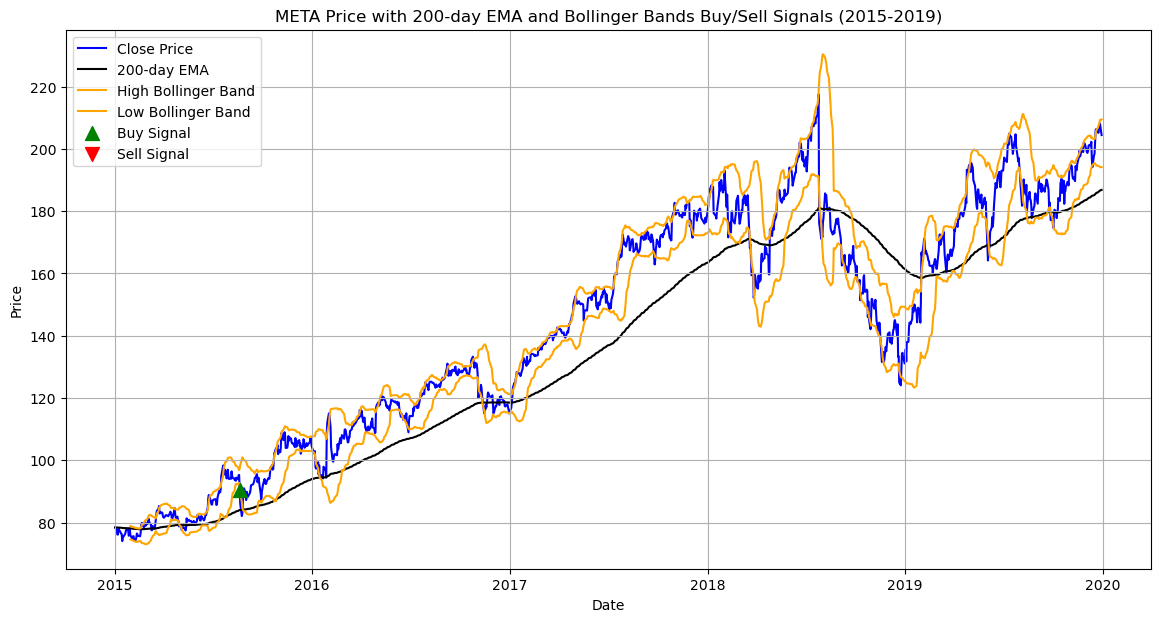

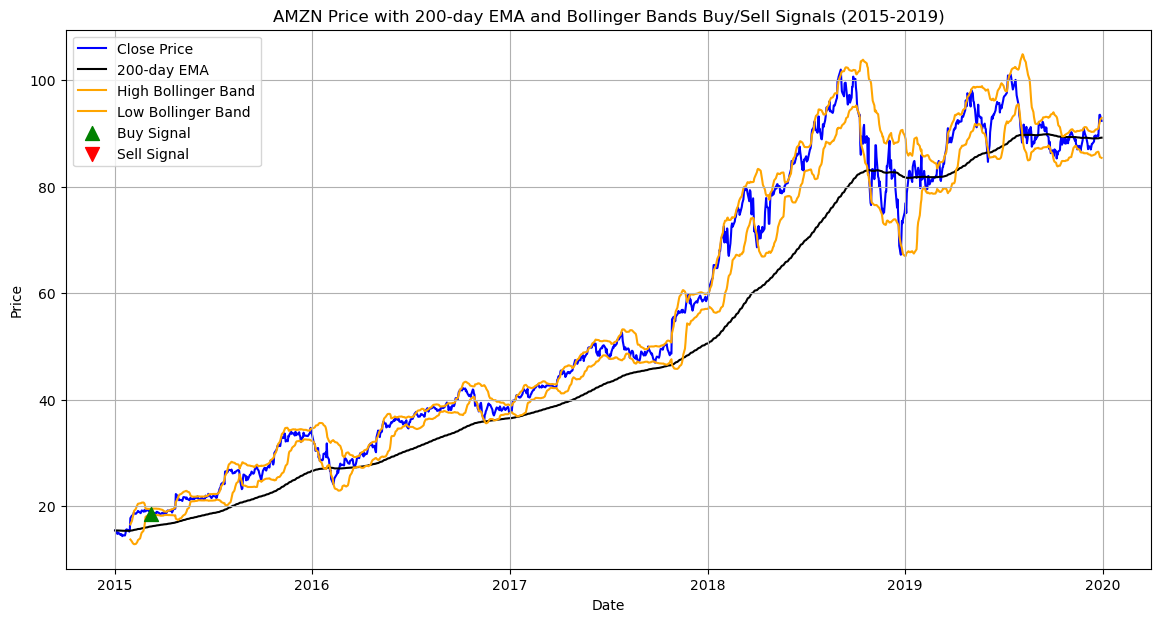

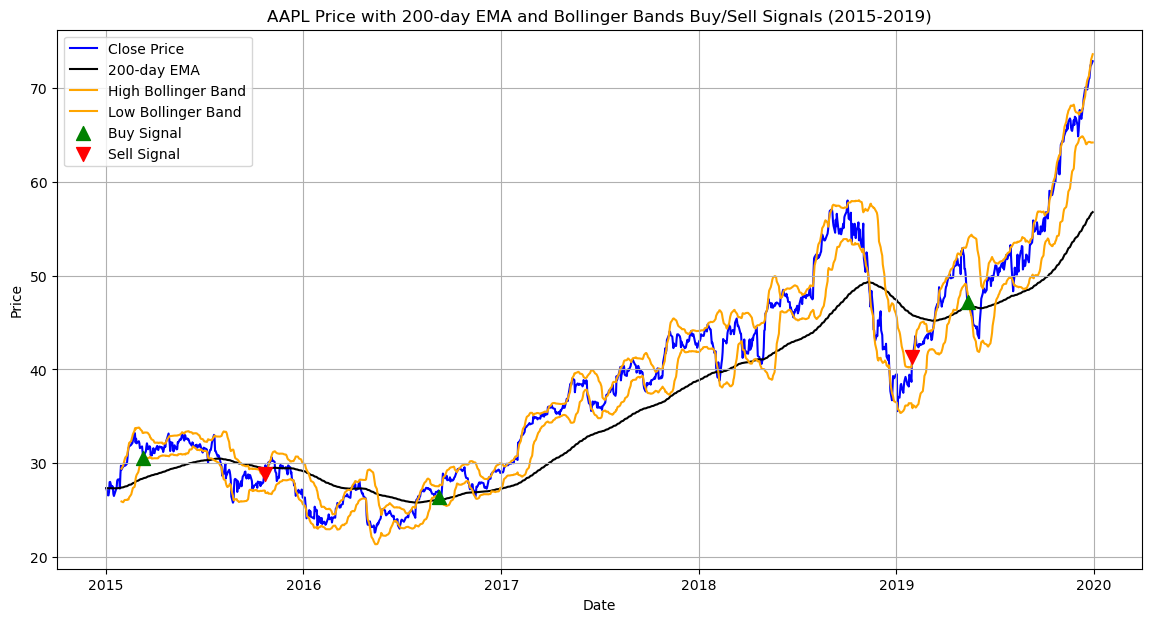

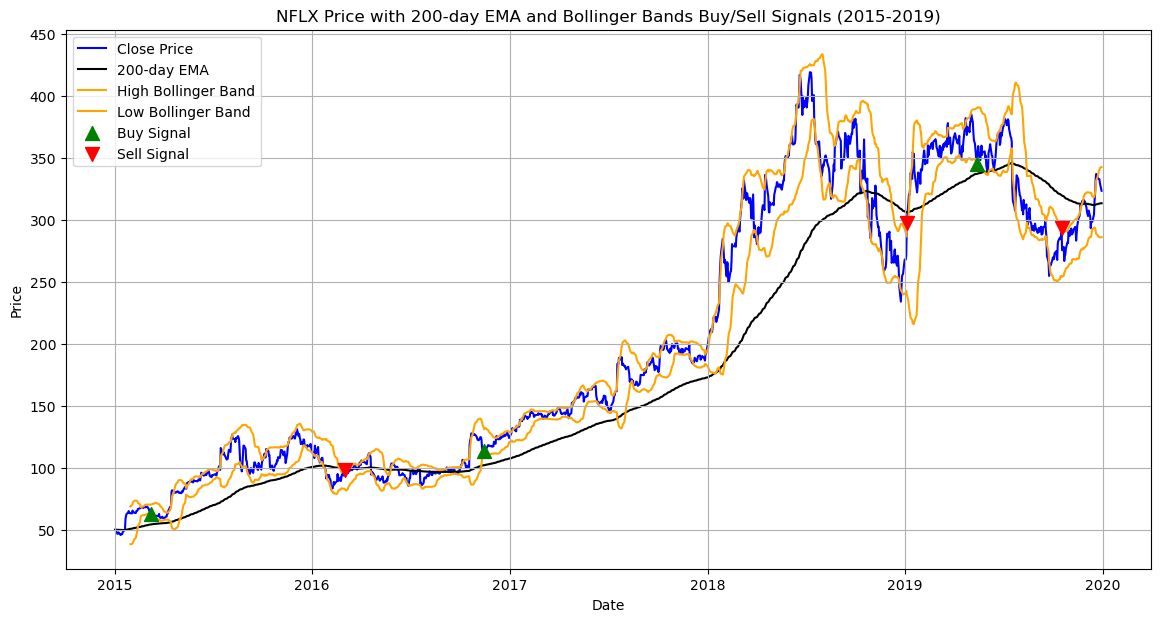

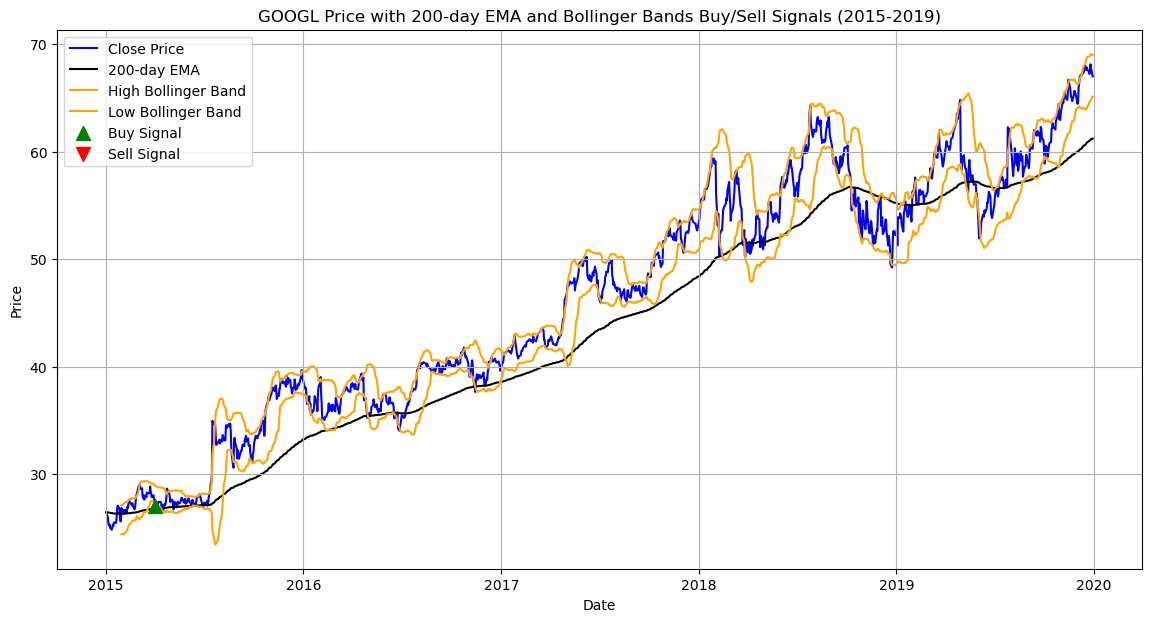

In [6]:
for stock in stockList:    
	# Visualization of price, 200-day EMA, and buy/sell signals
	plt.figure(figsize=(14, 7))
	plt.plot(stockList[stock]['strat']['Close'], label='Close Price', color='blue', zorder=1)
	plt.plot(stockList[stock]['strat']['EMA_200'], label='200-day EMA', color='black', zorder=1)
	plt.plot(stockList[stock]['strat']['bb_high'], label='High Bollinger Band', color='orange', zorder=1)
	plt.plot(stockList[stock]['strat']['bb_low'], label='Low Bollinger Band', color='orange', zorder=1)
	#plt.plot(stockList[google]['strat']['bb_mid'], label='20 Day Moving Average', color='black')

	buy_signals = stockList[stock]['strat'][(stockList[stock]['strat']['Position'] == 1) & (stockList[stock]['strat']['Position'].shift(1) != 1)]

	plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy Signal', s=100, zorder=2)

	# Plot Sell signals (MACD cross above zero and price below 200 EMA)
	sell_signals = stockList[stock]['strat'][(stockList[stock]['strat']['Position'] == -1) & (stockList[stock]['strat']['Position'].shift(1) != -1)]
	plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell Signal', s=100, zorder=2)

	plt.title(f'{stock} Price with 200-day EMA and Bollinger Bands Buy/Sell Signals (2015-2019)')
	plt.xlabel('Date')
	plt.ylabel('Price')
	plt.legend()
	plt.grid()
	plt.show()

# <font color = 'red'> 4.6.1.2 Buy/Sell Status of Stock </font>

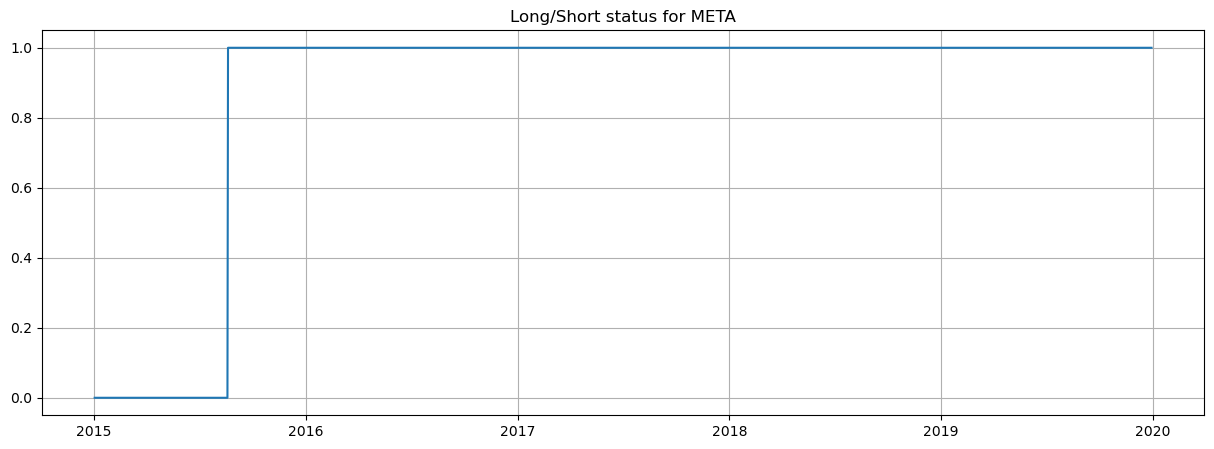

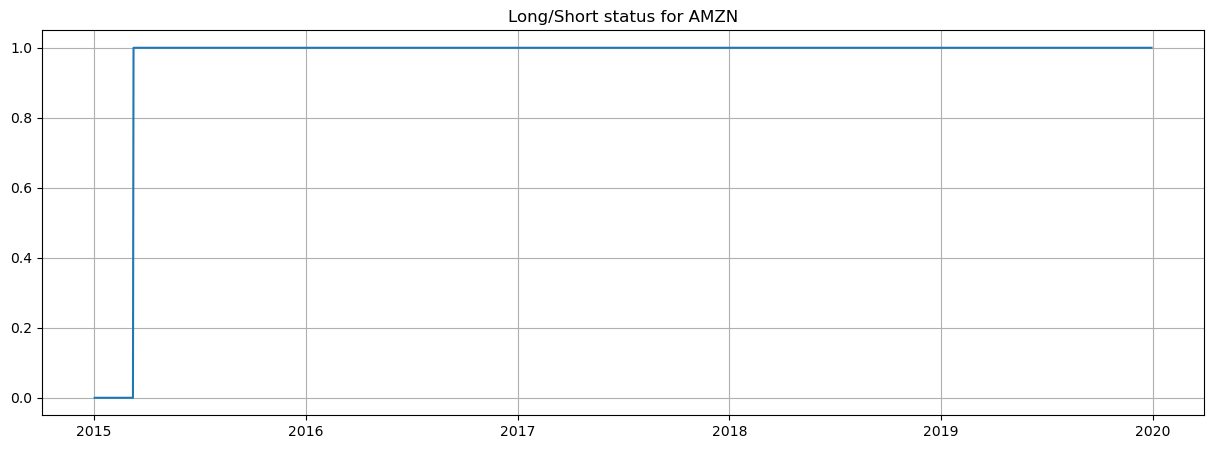

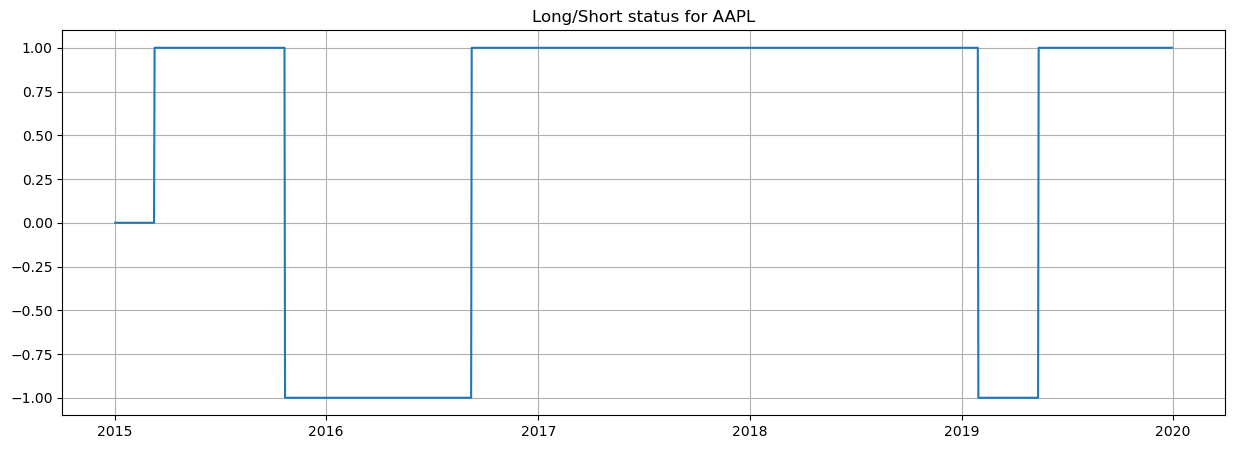

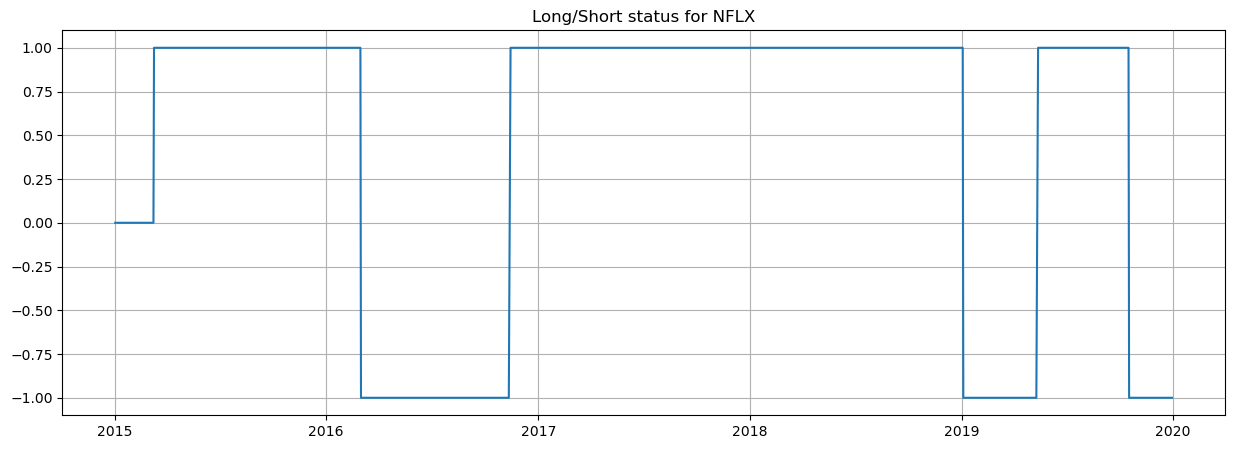

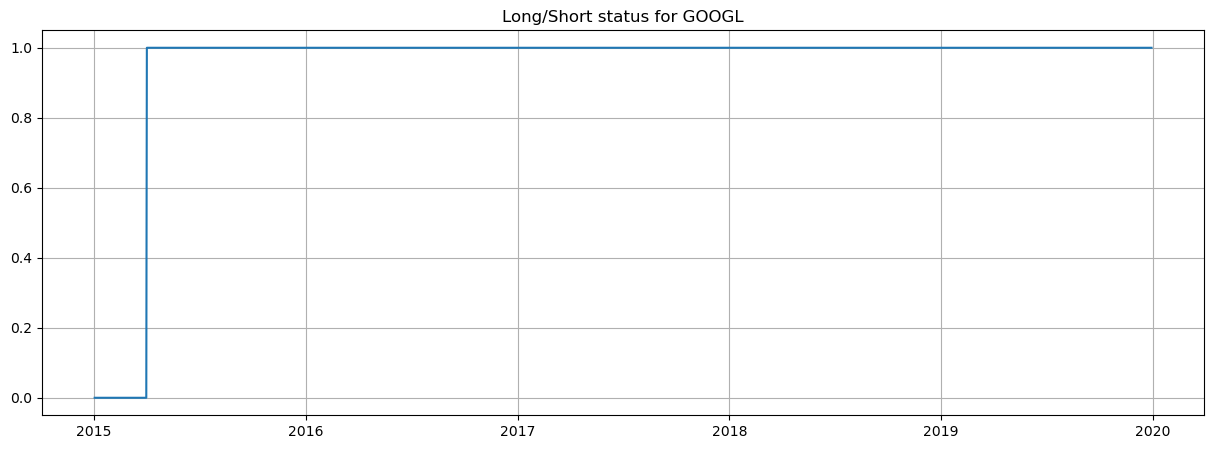

In [7]:
for stock in stockList:
	bt_data = stockList[stock]['strat']
	plt.figure(figsize=(15, 5))
	plt.plot(bt_data["Position"])
	plt.title(f"Long/Short status for {stock}")
	plt.grid()
	plt.show()

# <font color = 'red'> 4.6.2. Detailed View of Signals by Stock </font>

In [96]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd

app = dash.Dash(__name__)

# Dropdown options for stock selection
stock_options = [{'label': stock, 'value': stock} for stock in stockList.keys()]

# App layout
app.layout = html.Div(
    style={'display': 'flex', 'flexDirection': 'column', 'height': '100vh', 'padding': '10px'},
    children=[
        # Dropdown to select a stock
        dcc.Dropdown(
            id='stock-dropdown',
            options=stock_options,
            value=list(stockList.keys())[0], 
            clearable=False
        ),
        
        # can fit into 1 view by uncommenting but becomes a bit cluttered
        # Graph to display the stock chart (with price, EMA, and Bollinger Bands)
        dcc.Graph(
            id='stock-chart',
            #style={'flex': '1', 'height': '50%'}  # Take up half of the available height
        ),
        
        # Graph to display the Long/Short position status
        dcc.Graph(
            id='position-status',
            #style={'flex': '1', 'height': '50%'}  # Take up half of the available height
        )
    ]
)

# Callback to update the graphs when the dropdown value changes
@app.callback(
    [Output('stock-chart', 'figure'), Output('position-status', 'figure')],
    [Input('stock-dropdown', 'value')]
)
def update_graphs(selected_stock):
    # Get the data for the selected stock
    stock_data = stockList[selected_stock]['strat']

    # Create traces for the Close Price, EMA, and Bollinger Bands
    traces = [
        go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Close Price', line=dict(color='blue')),
        go.Scatter(x=stock_data.index, y=stock_data['EMA_200'], mode='lines', name='200-day EMA', line=dict(color='black')),
        go.Scatter(x=stock_data.index, y=stock_data['bb_high'], mode='lines', name='High Bollinger Band', line=dict(color='orange')),
        go.Scatter(x=stock_data.index, y=stock_data['bb_low'], mode='lines', name='Low Bollinger Band', line=dict(color='orange'))
    ]

    # Plot Buy Signals
    buy_signals = stock_data[(stock_data['Position'] == 1) & (stock_data['Position'].shift(1) != 1)]
    traces.append(go.Scatter(
        x=buy_signals.index, y=buy_signals['Close'], mode='markers', 
        marker=dict(color='green', size=15, symbol='triangle-up'),  # Buy signal
        name='Buy Signal'
    ))

    # Plot Sell Signals
    sell_signals = stock_data[(stock_data['Position'] == -1) & (stock_data['Position'].shift(1) != -1)]
    traces.append(go.Scatter(
        x=sell_signals.index, y=sell_signals['Close'], mode='markers', 
        marker=dict(color='red', size=15, symbol='triangle-down'),  # Sell signal
        name='Sell Signal'
    ))

    # Create the figure for the stock chart
    stock_chart_figure = {
        'data': traces,
        'layout': go.Layout(
            title=f'{selected_stock} Price with 200-day EMA and Bollinger Bands Buy/Sell Signals',
            xaxis_title='Date',
            yaxis_title='Price',
            legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
            hovermode='x'
        )
    }

    position_status_figure = {
        'data': [
            go.Scatter(
                x=stock_data.index, y=stock_data['Position'], mode='lines', name='Long/Short Status', 
                line=dict(color='purple')
            )
        ],
        'layout': go.Layout(
            title=f"Long/Short Status for {selected_stock}",
            xaxis=dict(
                title='Date',
                gridcolor='lightgrey'  # Set gridcolor inside the xaxis dictionary
            ),
            yaxis=dict(
                title='Position',
                tickvals=[-1, 0, 1],
                ticktext=['Short', 'Neutral', 'Long'],
                gridcolor='lightgrey'  # Set gridcolor inside the yaxis dictionary
            ),
            hovermode='x'
        )
    }


    return stock_chart_figure, position_status_figure

if __name__ == '__main__':
    app.run_server(debug=True, port=8050)


Obeservatons: (tune first)

- 

<hr>

# <font color = 'red'> 5. Performance Evaluation </font>

# <font color = 'red'> 5.1 Histogram of Daily Log Returns </font>

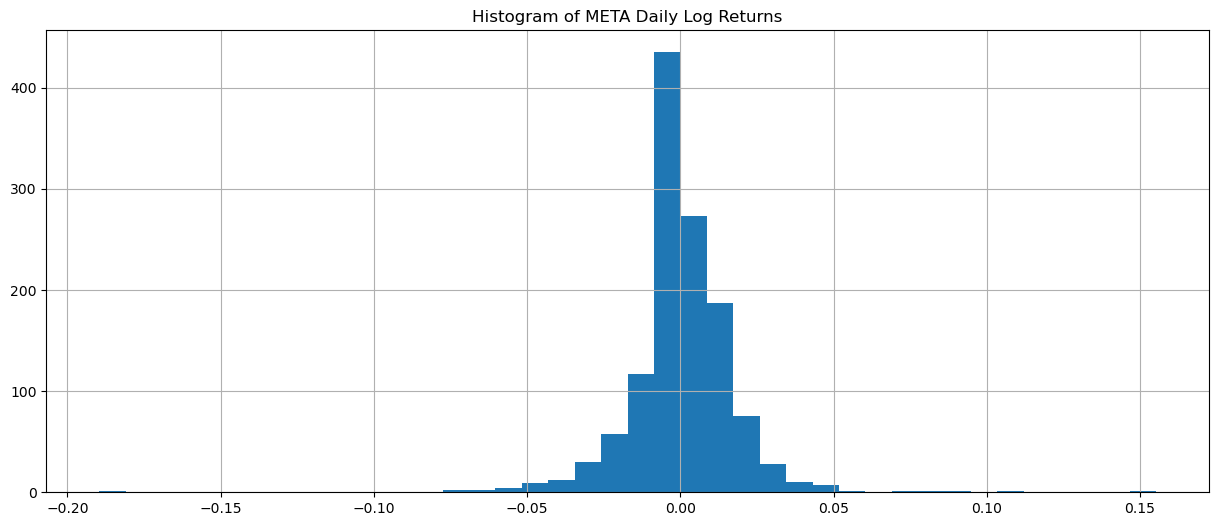

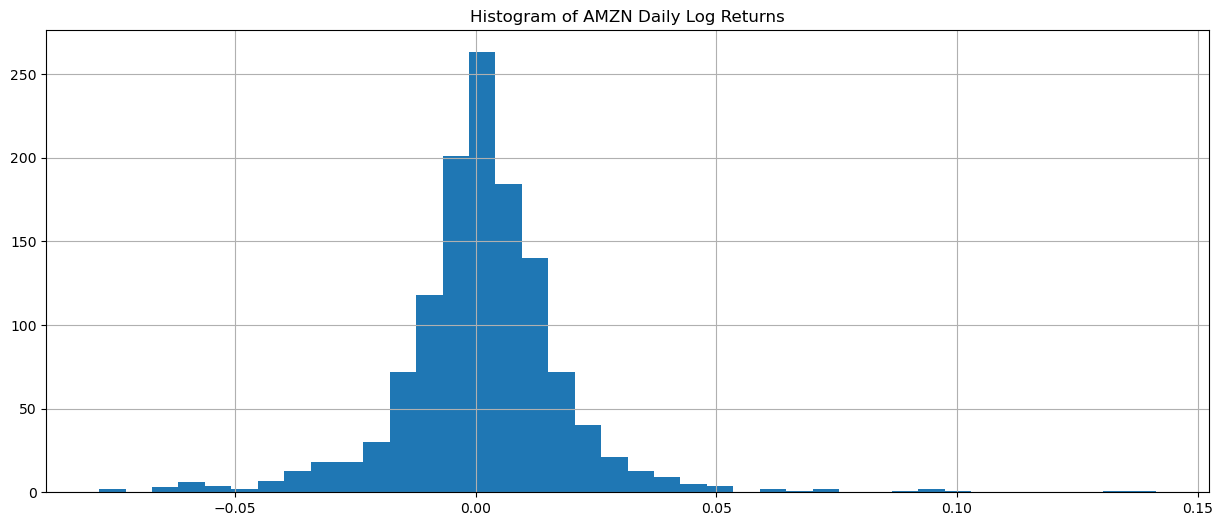

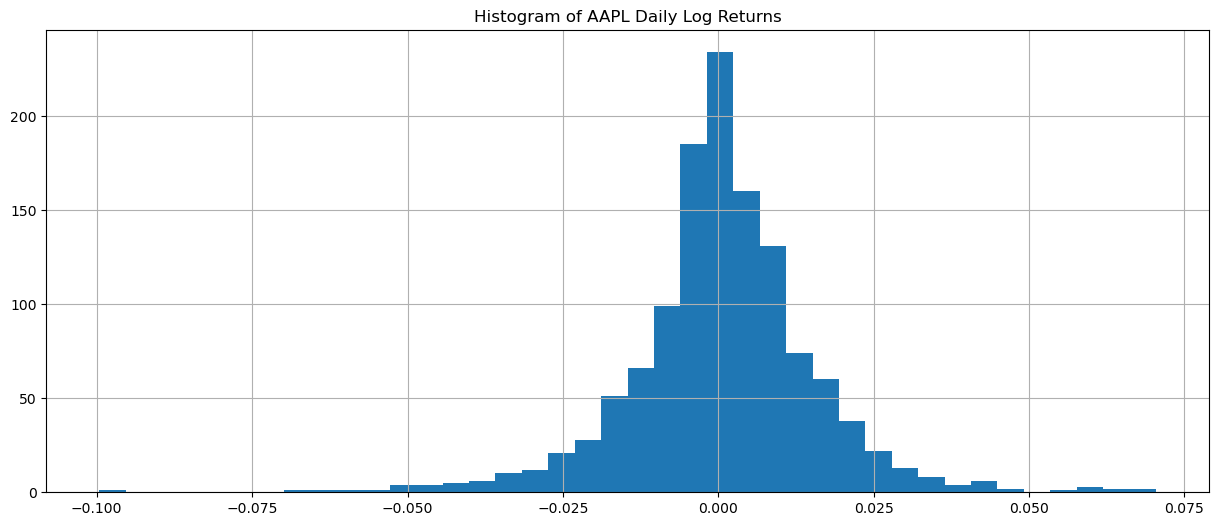

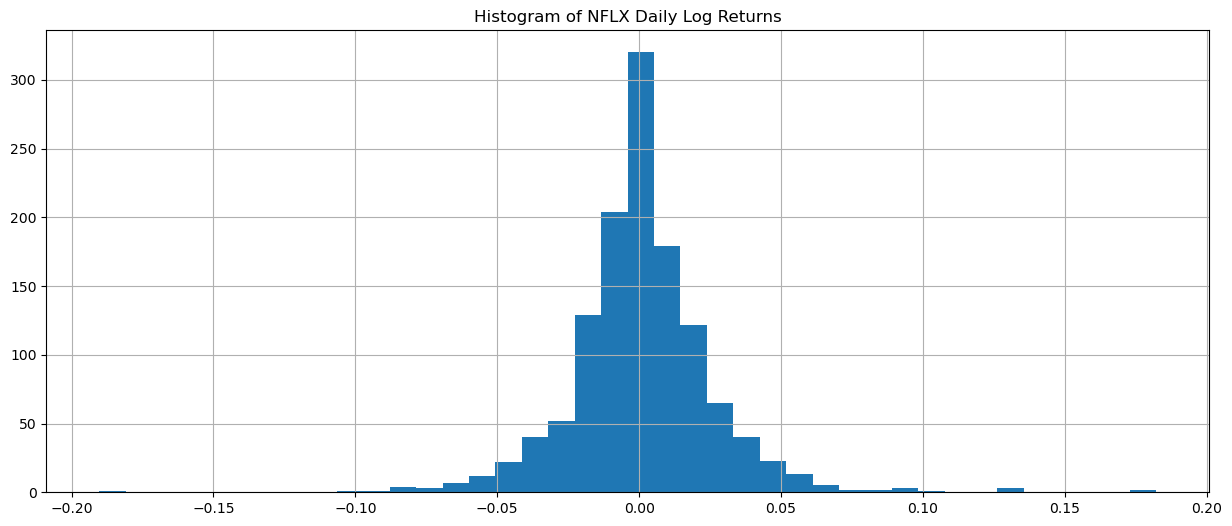

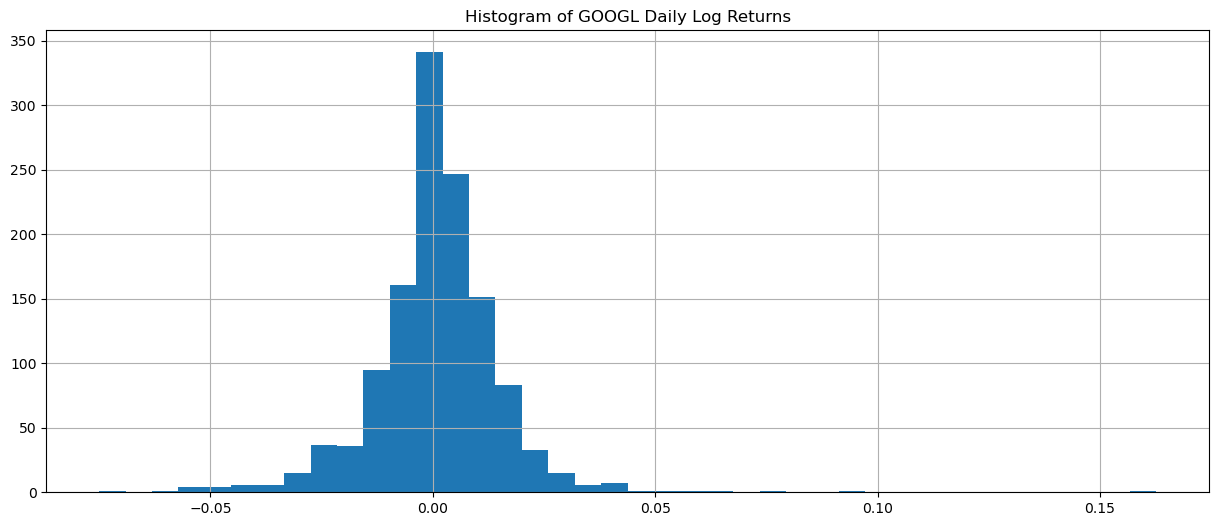

In [11]:
for stock in stockList:
	bt_data = stockList[stock]['strat']
	plt.figure(figsize=(15, 6))
	plt.hist(bt_data["Strategy_Return"], bins = 40)
	plt.title(f"Histogram of {stock} Daily Log Returns")
	plt.grid()
	plt.show()

# <font color = 'red'> 5.2. Cumulative Returns </font>

In [9]:
def calculate_returns(data):
	"""Calculate strategy and market returns."""
	data['Market_Return'] = data['Close'].pct_change()
	data['Strategy_Return'] = data['Position'].shift(1) * data['Market_Return']
	data['Cumulative_Strategy_Return'] = (data['Strategy_Return'] + 1).cumprod() - 1
	data['Cumulative_Market_Return'] = (data['Market_Return'] + 1).cumprod() - 1
	data["Gross_Cum_Returns"] = bt_data["Strategy_Return"].cumsum().apply(np.exp) # Same as what we did earlier to visulaise over time
	data["Cum_Max"] = bt_data["Gross_Cum_Returns"].cummax()
	return data

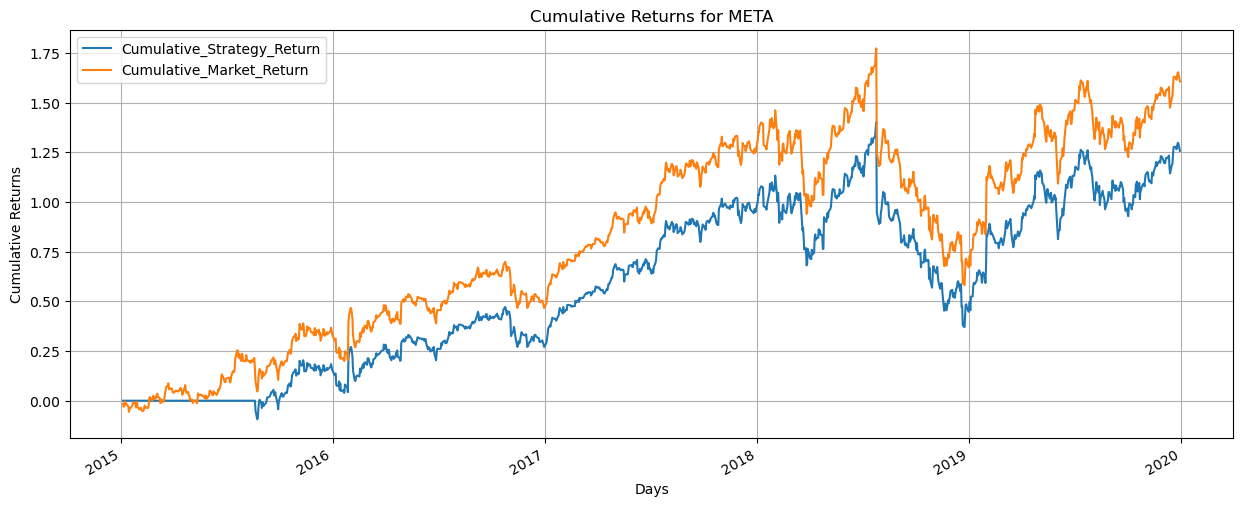

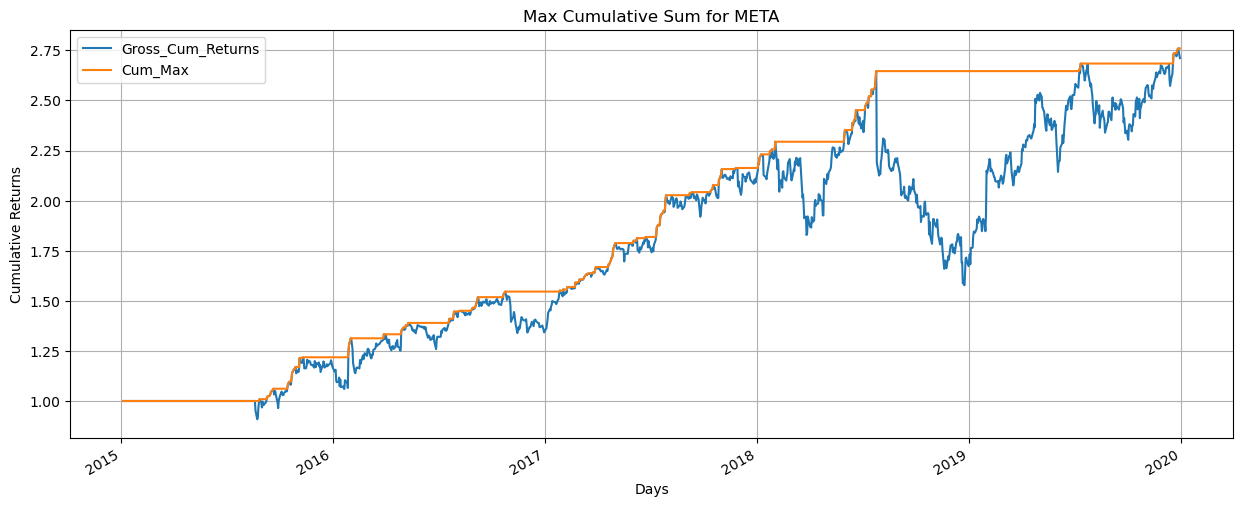

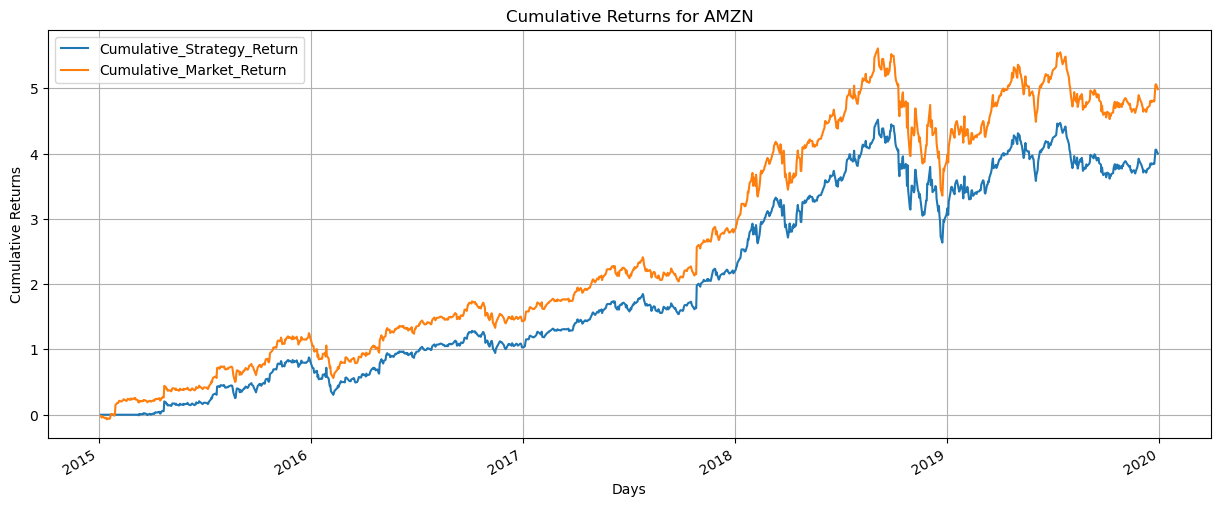

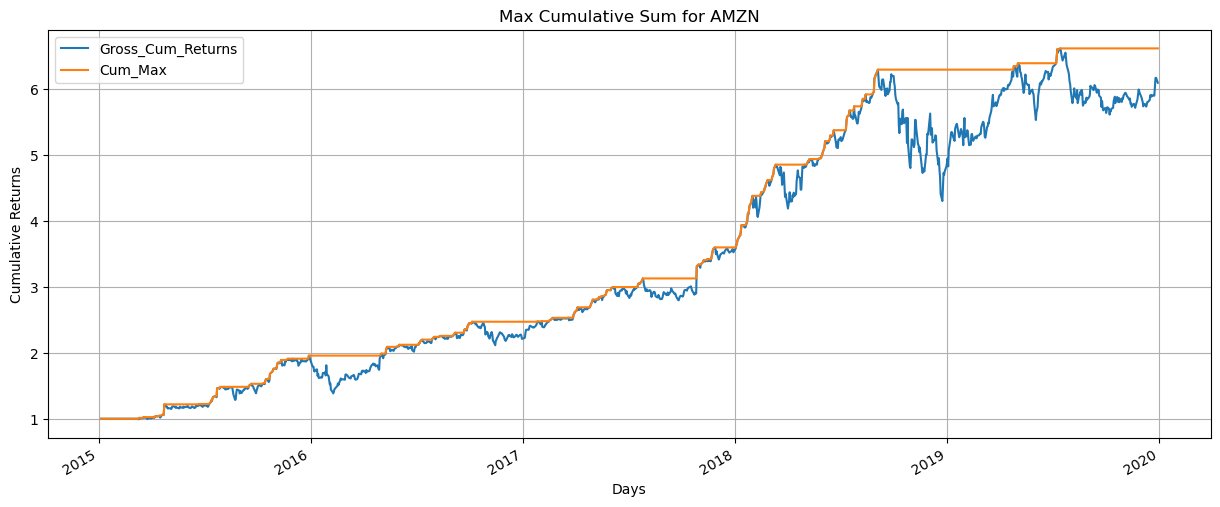

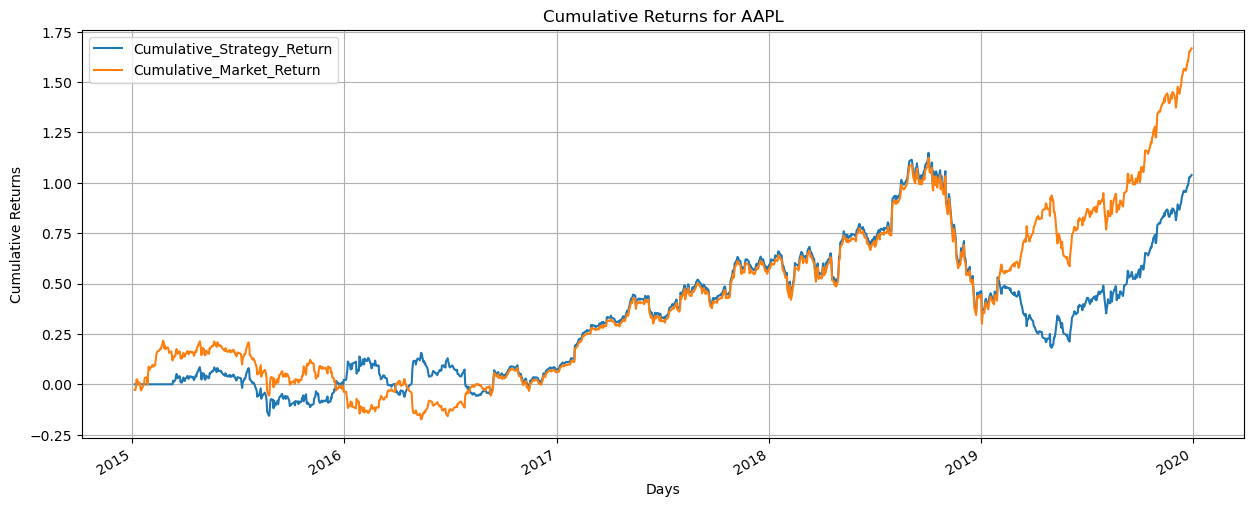

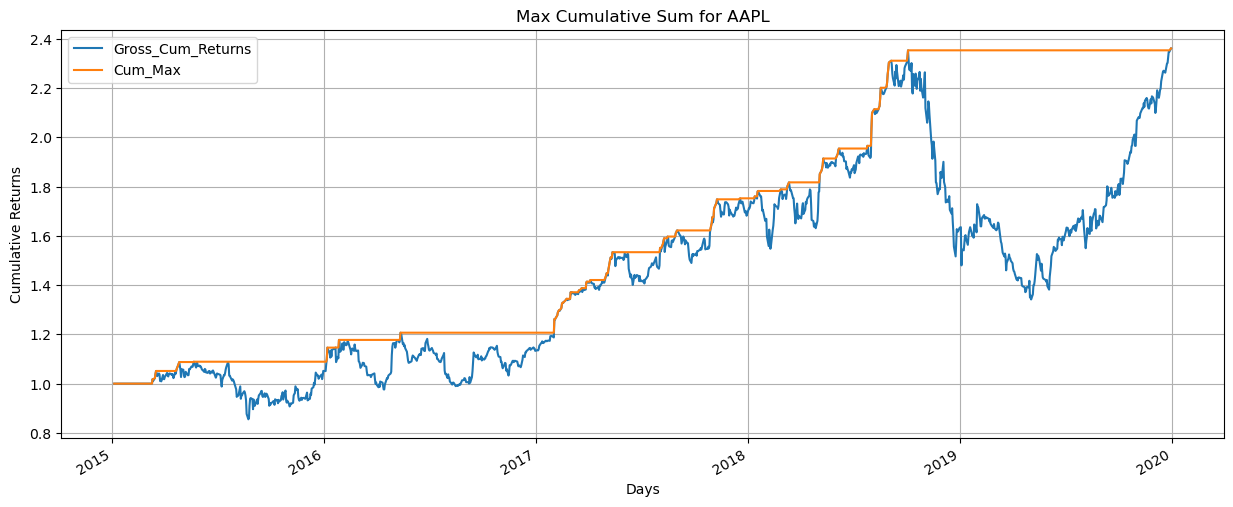

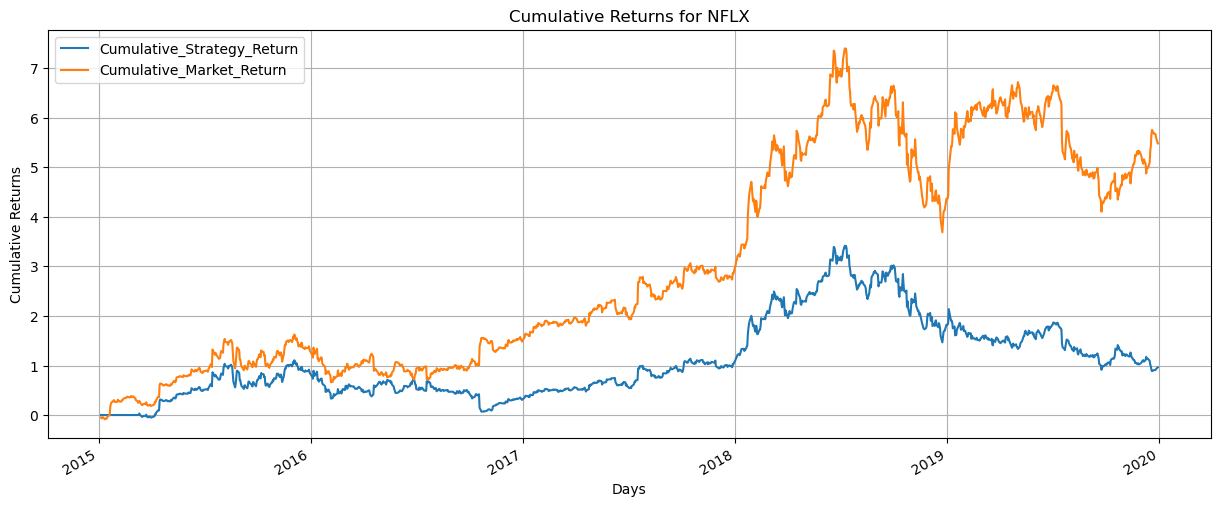

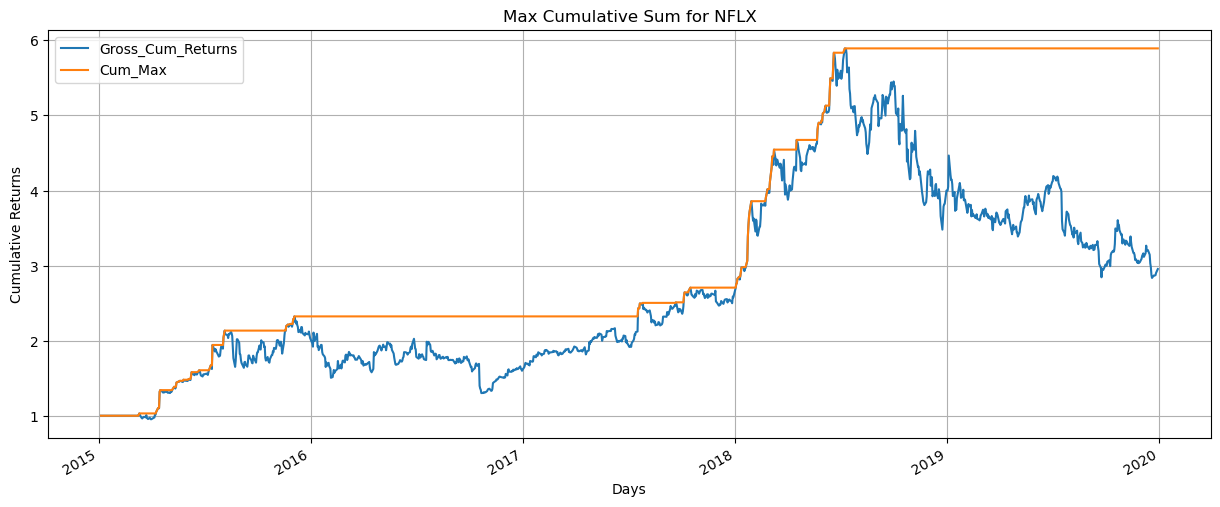

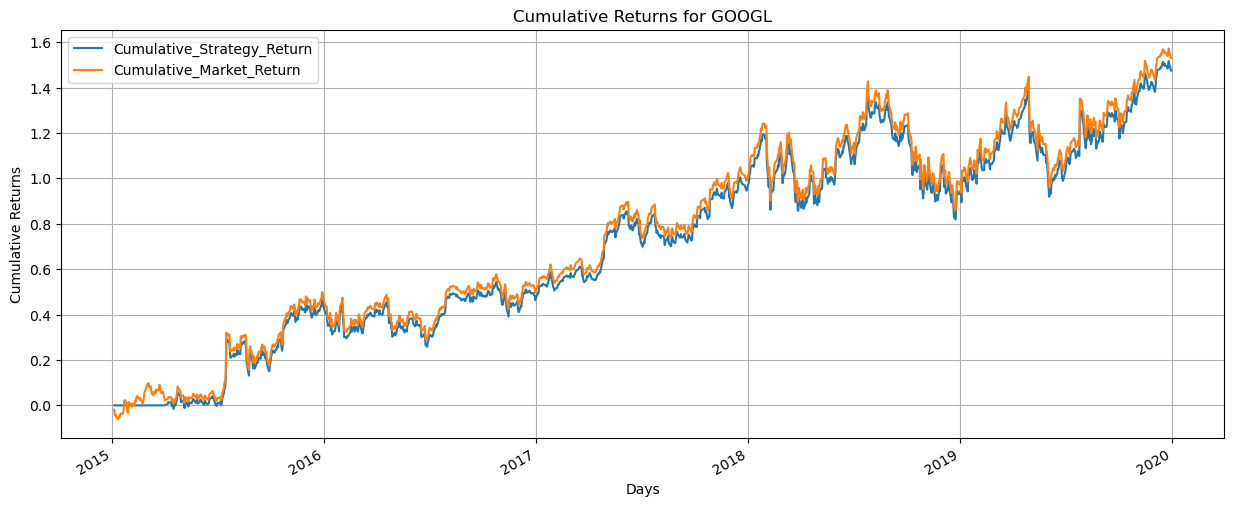

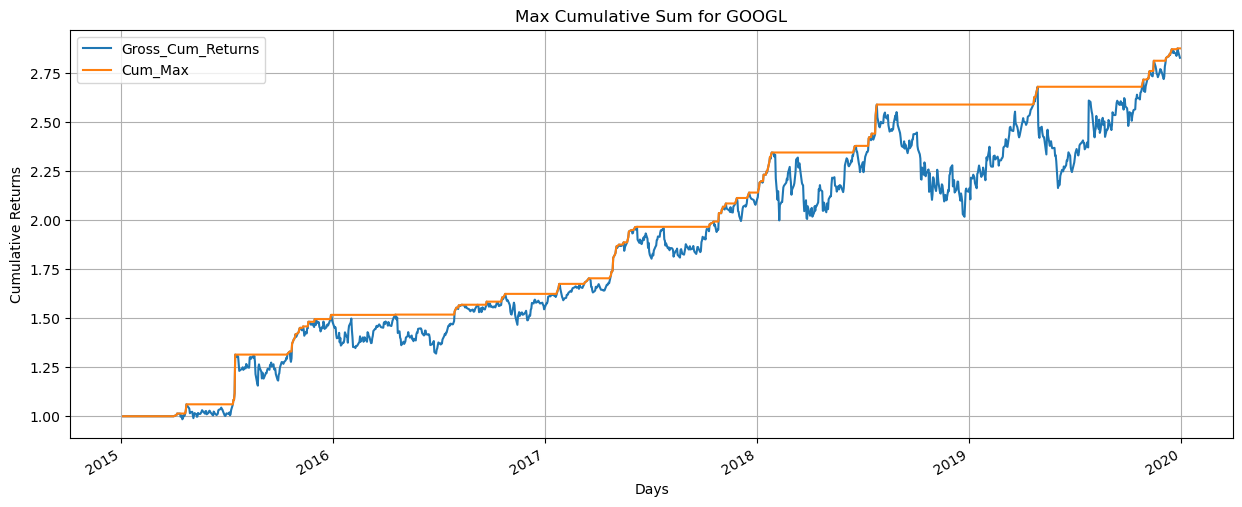

In [10]:
for stock in stockList:
    bt_data = stockList[stock]['strat']
    bt_data = calculate_returns(bt_data)

    # Cumulative returns plot
    bt_data[["Cumulative_Strategy_Return", "Cumulative_Market_Return"]].plot(figsize=(15, 6))
    plt.title(f'Cumulative Returns for {stock}')
    plt.xlabel("Days")
    plt.ylabel("Cumulative Returns")
    plt.grid()
    plt.show()
    
    bt_data[["Gross_Cum_Returns", "Cum_Max"]].dropna().plot(figsize =(15,6))
    plt.title(f'Max Cumulative Sum for {stock}')
    plt.xlabel("Days")
    plt.ylabel("Cumulative Returns")
    plt.grid()
    plt.show()

# <font color = 'red'> 5.2 Interactable Version of Cumulative Returns </font>

In [12]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objs as go

app = dash.Dash(__name__)

# Dropdown options for stock selection
stock_options = [{'label': stock, 'value': stock} for stock in stockList.keys()]

# App layout
app.layout = html.Div(style={'display': 'flex', 'flexDirection': 'column', 'height': '100vh', 'padding': '10px'}, children=[
    # Dropdown to select a stock
    dcc.Dropdown(
        id='stock-dropdown',
        options=stock_options,
        value=list(stockList.keys())[0], 
        clearable=False,
        style={'width': '100%'}
    ),
    
    # Graph for cumulative returns
    dcc.Graph(
        id='cumulative-returns',
        style={'flex': '1', 'height': '50vh'}  # Take up half of the viewport height
    ),
    
    # Graph for max cumulative sum
    dcc.Graph(
        id='max-cumulative-sum',
        style={'flex': '1', 'height': '50vh'}  # Take up half of the viewport height
    )
])

# Callback to update the graphs when the dropdown value changes
@app.callback(
    [Output('cumulative-returns', 'figure'), Output('max-cumulative-sum', 'figure')],
    [Input('stock-dropdown', 'value')]
)
def update_graphs(selected_stock):
    # Get the data for the selected stock
    bt_data = stockList[selected_stock]['strat']
    bt_data = calculate_returns(bt_data)
    
    # Cumulative returns figure
    cumulative_returns_figure = {
        'data': [
            go.Scatter(x=bt_data.index, y=bt_data['Cumulative_Strategy_Return'], mode='lines', name='Cumulative Strategy Return', line=dict(color='blue')),
            go.Scatter(x=bt_data.index, y=bt_data['Cumulative_Market_Return'], mode='lines', name='Cumulative Market Return', line=dict(color='orange'))
        ],
        'layout': go.Layout(
            title=f'Cumulative Returns for {selected_stock}',
            xaxis_title='Days',
            yaxis_title='Cumulative Returns',
            hovermode='x'
        )
    }
    
    # Max cumulative sum figure
    max_cumulative_sum_figure = {
        'data': [
            go.Scatter(x=bt_data.index, y=bt_data['Gross_Cum_Returns'], mode='lines', name='Gross Cumulative Returns', line=dict(color='green')),
            go.Scatter(x=bt_data.index, y=bt_data['Cum_Max'], mode='lines', name='Cumulative Maximum', line=dict(color='red'))
        ],
        'layout': go.Layout(
            title=f'Max Cumulative Sum for {selected_stock}',
            xaxis_title='Days',
            yaxis_title='Cumulative Returns',
            hovermode='x'
        )
    }
    
    return cumulative_returns_figure, max_cumulative_sum_figure

if __name__ == '__main__':
    app.run_server(debug=True, port=8051)


# <font color = 'red'> 6. Performance Metrics</font>

In [17]:
def sharpe_ratio(data, risk_free_rate=0.0):
    """Calculate the Sharpe ratio of the strategy."""
    excess_return = data['Strategy_Return'] - risk_free_rate / 252
    return np.sqrt(252) * excess_return.mean() / excess_return.std()

def sortino_ratio(data, risk_free_rate=0.0):
    """Calculate the Sortino ratio of the strategy."""
    excess_return = data['Strategy_Return'] - risk_free_rate / 252
    negative_return = data['Strategy_Return'][data['Strategy_Return'] < 0]
    downside_deviation = np.std(negative_return) * np.sqrt(252)
    return (excess_return.mean() * 252) / downside_deviation

def treynor_ratio(data, beta, risk_free_rate=0.0):
    """Calculate the Treynor ratio of the strategy."""
    excess_return = data['Strategy_Return'] - risk_free_rate / 252
    return (excess_return.mean() * 252) / beta

def max_drawdown(data):
    """Calculate the maximum drawdown of the strategy."""
    cumulative = (data['Strategy_Return'] + 1).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

def tracking_error(data):
    """Calculate the tracking error of the strategy vs. the benchmark."""
    active_return = data['Strategy_Return'] - data['Market_Return']
    return np.std(active_return) * np.sqrt(252)

def information_ratio(data):
    """Calculate the information ratio of the strategy vs. the benchmark."""
    active_return = data['Strategy_Return'] - data['Market_Return']
    return (active_return.mean() * 252) / tracking_error(data)

def beta(data):
    """Calculate the beta of the strategy against the benchmark."""
    covariance = data[['Strategy_Return', 'Market_Return']].cov().iloc[0, 1]
    variance_market = data['Market_Return'].var()
    return covariance / variance_market

def alpha(data, risk_free_rate=0.00):
    """Calculate the alpha of the strategy against the benchmark."""
    beta_value = beta(data)
    market_return_annualized = data['Market_Return'].mean() * 252
    strategy_return_annualized = data['Strategy_Return'].mean() * 252
    return strategy_return_annualized - (risk_free_rate + beta_value * (market_return_annualized - risk_free_rate))

def standard_deviation(data):
    """Calculate the annualized standard deviation of the strategy returns."""
    return data['Strategy_Return'].std() * (252 ** 0.5)


In [18]:
for stock in stockList:
	bt_data = stockList[stock]['strat']
	sharpe = sharpe_ratio(bt_data)
	sortino = sortino_ratio(bt_data)
	treynor = treynor_ratio(bt_data, beta=1.2)
	maxDrawdown = max_drawdown(bt_data)
	trackingError = tracking_error(bt_data)
	informationRatio = information_ratio(bt_data)
	betaInfo = beta(bt_data)
	alphaInfo = alpha(bt_data)
	stddev = standard_deviation(bt_data)

	print(f"--- Performance Metrics for {stock}")
	print(f"Beta: {betaInfo}")
	print(f"Alpha: {alphaInfo}")

	print(f"Sharpe Ratio: {sharpe}")
	print(f"Standard Deviation: {stddev}")

	print(f"Sortino Ratio: {sortino}")
	print(f"Treynor Ratio: {treynor}")
	print(f"Max Drawdown: {maxDrawdown}")
	print(f"Tracking Error: {trackingError}")
	print(f"Information Ratio: {informationRatio}")
	print("\n")


--- Performance Metrics for META
Beta: 0.9141571413161909
Alpha: -0.01228244058232919
Sharpe Ratio: 0.7412384153725899
Standard Deviation: 0.26995616719751825
Sortino Ratio: 0.8688861317566831
Treynor Ratio: 0.16675156799462199
Max Drawdown: -0.4296092066271554
Tracking Error: 0.0828317856676006
Information Ratio: -0.38905526479375424


--- Performance Metrics for AMZN
Beta: 0.9320614158135422
Alpha: -0.011686294541786435
Sharpe Ratio: 1.2830090791317785
Standard Deviation: 0.28260181396137724
Sortino Ratio: 1.8051457796284118
Treynor Ratio: 0.3021505775762973
Max Drawdown: -0.34103783046300706
Tracking Error: 0.07660724239312046
Information Ratio: -0.5086577464408726


--- Performance Metrics for AAPL
Beta: 0.47790474419547274
Alpha: 0.06348052012152232
Sharpe Ratio: 0.7106290819848474
Standard Deviation: 0.2425433379564525
Sortino Ratio: 0.9494625521131244
Treynor Ratio: 0.14363195799461204
Max Drawdown: -0.45027085891789403
Tracking Error: 0.2480156447045765
Information Ratio: -0.22

# <font color = 'red'> 7. MAANG Portfolio Returns</font>